# Generalised Linear Models - this is different to a 'general linear model'

Linear regression is great for building models where the response variables are linear combinations of the predictor variables, (i.e. a when we expect that a constant change in a predictor variable leads to a constant change in the response). In this case, there's no real upper or lower bounds on the values that the response variables can take. This is appropriate for responses variables with Normal distributions.

However, we've already seen some of the limitations of linear regression. Recall that with our American election data, we were trying to model the proportion of a population that votes Republican in an election. We want our predictions here to be bounded between 0 and 1, but if we modelled this with linear regression, we could easily end up with predictions that were less than 0 or greater than 1. We have a different type of relationship between the predictors and the response here. 

Generalized linear models help us model things more broadly by allowing for response variables that take any type of distribution (rather than just Normal). Even more helpful, rather than requiring that the response variable be linear combinations of the predictor variables, they allow for some *function* of the response variable to have this linear relationship.

In [1]:
import tqdm

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

from tqdm import trange, tqdm

# Maximum Likelihood Estimation

First we need to understand maximum likelihood estimation (MLE). It is actually very simple. Maximum likelihood estimate is the most likely estimate of some unknown parameter.

For example, if you have have a set a data below for a random sample of human IQ and you believe it comes from a normal distribution with some unknown mean and standard deviation ( $\mathcal{N}(\mu, \sigma)$ ) then we can use optimisation to find which values for the mean and standard deviation maximises the likelihood.

given that you flip 3 heads and 2 tails, what is the most likley probability that a coin flip lands on heads. 60%. a coin was used in the example on purpose. in this example we dont know anything about the the history of the coin. pertend if the exmplae was instead a button that outputs h or t
    - this is the example stephen gave in class. 

C:\Users\Kris\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


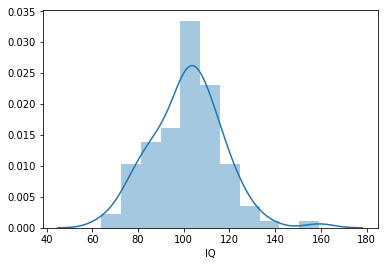

In [3]:
true_mean, true_sd = 100, 15
iqs = stats.norm(true_mean, true_sd).rvs(100)

sns.distplot(iqs)
plt.xlabel('IQ')
plt.show()

the top formula uses an upside down U, this is to multiple up all the pieces of the formula after the upside down U. 

the likleihood you see some data is based on some parameter of that data.

likliehood is different from probability. 

log liklihood is used because computers struggle to multiply decimals. if you multiply two decimals the number gets smaller. very quickly the number gets too small for computers to handle. therefore we use log.

multiply a bunch of numbers is the same as adding up the logs of those numbers. 

The likelihood of your all your data can be computed by calculating the cumulative product of the likelihood of each data point...

$$ L(x|\theta) = \prod L(x_i | \theta) $$

Where theta is your guess of the model's parameter values.

NOTE: Since computers cannot compute the product of extremely small numbers we need to rewrite this equation. Hopefully from calculus you remember that the cumlative product of a set of numbers is equal to the sum of set of the log of those numbers.

$$ logL(x|\theta) = \sum logL(x_i | \theta) $$

The model's likelihood can be computed using the `.pdf(data)` function for likelihoods and `.logpdf(data)` for log likelihoods.

In [4]:
# Quick Question: What's more likely, 1 person with an IQ of 155 or 3 people with IQs of 100?
print(f'1 155IQ:', stats.norm(true_mean, true_sd).pdf(155))
print(f'3 100IQ:', stats.norm(true_mean, true_sd).pdf([100, 100, 100]).prod())

1 155IQ: 3.2018043441388044e-05
3 100IQ: 1.881292916570103e-05


the above example works because because we are multipling the 100's together. 

also the above works because we are using normal distribution. if data was INCREDILBY centralized with a small SD the above exmplae would start to stop working.

In [5]:
# Unlikely values
print(stats.norm(0, 1).pdf(iqs).prod())  # Notice that the value of this is equal to zero.

# More likely values
print(stats.norm(90, 20).pdf(iqs).prod())

# True values
print(stats.norm(true_mean, true_sd).pdf(iqs).prod())

0.0
4.381759174209318e-191
8.07306445371078e-182


note the above difference in liklihood is 10^9, like billions of times for likley.

if you do the above example with less data points (try with 4), then the liklihoods of 90,20 are much closer to true_mean and true_sd than when we use lots of data point

In [7]:
# Unlikely values
print(stats.norm(0, 1).logpdf(iqs).sum())

# More likely values
print(stats.norm(90, 20).logpdf(iqs).sum())

# True values
print(stats.norm(true_mean, true_sd).logpdf(iqs).sum())

-527565.5433617814
-438.3163024801619
-416.98195378067413


The awesome thing about likehoods is just how little bad values of $\theta$ reduces the model fit. Notice that in the example above just being 10 off on the mean and 5 off on the standard deviation yielded parameters that were 1 billion times less likely. 

### Exercise
1. Write an optimiser to find the most likely parameters for our data given it came from a normal distribution.

In [ ]:
mean = 0
std = 0
def optimizer(data, mean, std):
  
    solution = stats.norm(mean, std).logpdf(data).sum()
    if stats.norm(mean+1, std+1).logpdf(data).sum() - stats.norm(mean, std).logpdf(data).sum() >1:
        def optimizer(data, mean-1, std-1)
    elif
        retu
        

In [8]:
# Boilerplate
def objective_function(params, data):
    return 0

#mle_mean, mle_sd = opt.fmin(objective_fuction, initial_guess, (extra_args,))

In [21]:
# Solution
# Since most optimisers minimise functions we will multiple our likelihood by -1
def norm_mle(params, data):
    mu, sd = params
    return -stats.norm(mu, sd).logpdf(data).sum() #  notice this is negitive. 

mle_mean, mle_sd = opt.fmin(norm_mle, [50, 50], (iqs,))
print(mle_mean, mle_sd)

TypeError: norm_mle() missing 1 required positional argument: 'data'

In [10]:
print(iqs.mean(), iqs.std())

101.52599564297141 15.55458771142999


# GLMs

What does this have to do with GLMs? Well in a generalised linear model we will be trying to find the MLE of the parameters directly. However, with ordinary least squares regression, the model optimises the mean squared error which _should_ give us the expected value of $y$ given $X$. 

So let's describe a GLM for normal linear regression. 

$$ y \sim \mathcal{N}(Xm, \sigma) $$

- the above sigma is for the residuals
- fancy N is normal distribution



This says $y$ comes from a normal distribution where the mean is the function $Xm$ and the standard deviation is $\sigma$.

It can also be rewritten with respect to the residuals. Which is the form most optimisers compute the solution for.

$$ (y - Xm) = residuals \sim \mathcal{N}(0, \sigma) $$

In [19]:
# Let's create some fake data
# Create data with slope -5 and intercept 2
m = np.asmatrix([2, -5]).T
n = 500

x = stats.uniform().rvs((n, 1))
x = sm.add_constant(x)
y = x @ m + stats.norm(0, 2).rvs((len(x), 1))
print(y.shape)

# plt.plot(x[:, 1], y, 'o')
# plt.plot(x[:, 1], x @ m, '.')
# plt.show()

# sns.distplot(y - y.mean())
# plt.xlabel('Variance Y')
# plt.show()

# sns.distplot(y - x@m, fit=stats.norm)
# plt.xlabel('Residuals')
# plt.show()

m

(500, 1)


matrix([[ 2],
        [-5]])

### Execerise
1. Let's try to make an optimiser that finds the params for our linear model. (Assume the the residuals are normally distributed).

In [15]:
def objective_function(params, data):
    return 0


In [ ]:
def norm_mle(params, data):
    m, b, sigma = params
    
    model = x @ m + stats.norm(0, 2).rvs((len(x), 1))
    
    residuals = 
    return -stats.norm(0, sd).logpdf(residuals).sum() #  notice this is negitive. 

mle_mean, mle_sd = opt.fmin(norm_mle, [50, 50], (iqs,))
print(mle_mean, mle_sd)

In [ ]:
# Boilerplate
def glm_objective(params, data):
    return 0

# mle_m = opt.fmin(glm_objective, initial_guess, (extra_args,))

In [25]:
# Solution
def glm_objective(params, data, target):
    print(data)
    m_i, sigma_i = np.asmatrix(params[:-1]).T, params[-1]
    y_hat = data @ m_i
    resids = target - y_hat
    return -stats.norm(0, sigma_i).logpdf(resids).sum()

mle_params = opt.fmin(glm_objective, np.array([2, 2, 2]), (x, y)) # the x and y in this example are the data and target in 
# the objective function. 

mle_sigma = mle_params[-1]
mle_params = mle_params[:-1]

# print(mle_params)
# print(mle_sigma)

     worst fractal dimension  perimeter error  mean area  worst perimeter  \
0                    0.11890           8.5890     1001.0           184.60   
1                    0.08902           3.3980     1326.0           158.80   
2                    0.08758           4.5850     1203.0           152.50   
3                    0.17300           3.4450      386.1            98.87   
4                    0.07678           5.4380     1297.0           152.20   
5                    0.12440           2.2170      477.1           103.40   
6                    0.08368           3.1800     1040.0           153.20   
7                    0.11510           3.8560      577.9           110.60   
8                    0.10720           2.4060      519.8           106.20   
9                    0.20750           2.0390      475.9            97.65   
10                   0.08452           2.4660      797.8           123.80   
11                   0.10480           3.5640      781.0           136.50   

[569 rows x 10 columns]


ValueError: Dot product shape mismatch, (569, 10) vs (2, 1)

model has no bias if residuals are centered on zero. 

# Statsmodels GLM

Statsmodels has a GLM function that allows you to do all of this easily. Precisely how this is done is not exactly the same but the goal is identical, that is, fit the residuals to a particular distribution.

For data where the residuals are normally distributed the default values are fine, however whenever the residuals deviate for some other reason then we'll need to modify the 'link functions' and 'family'. Basically all packages will pair the appropriate linker function for each family

## GLM Logistic Regression (_Family = Binomial_)

In [22]:
# Let's quickly prepare the data
from sklearn.datasets import load_breast_cancer

breast = load_breast_cancer()
x = pd.DataFrame(breast.data, columns=breast.feature_names)
x = x.sample(10, axis=1, random_state=1992)
y = breast.target  # 0 is benign and 1 is malignant

display(x.head())
print(y)

,worst fractal dimension,perimeter error,mean area,worst perimeter,mean radius,smoothness error,concave points error,worst compactness,radius error,concavity error
0,0.11890,8.589,1001.0,184.60,17.99,0.006399,0.01587,0.6656,1.0950,0.05373
1,0.08902,3.398,1326.0,158.80,20.57,0.005225,0.01340,0.1866,0.5435,0.01860
2,0.08758,4.585,1203.0,152.50,19.69,0.006150,0.02058,0.4245,0.7456,0.03832
3,0.17300,3.445,386.1,98.87,11.42,0.009110,0.01867,0.8663,0.4956,0.05661
4,0.07678,5.438,1297.0,152.20,20.29,0.011490,0.01885,0.2050,0.7572,0.05688


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

Now let's create and fit a model like we have in other cases.

In [23]:
logit_glm = sm.GLM(y, x, family=sm.families.Binomial()).fit() # familys are reffering to the distribution of the residuals
# we are doing a logistic regression here by specifying Binomial residuals. 

display(logit_glm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  569
Model:                            GLM   Df Residuals:                      559
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62.554
Date:                Mon, 29 Oct 2018   Deviance:                       125.11
Time:                        15:58:44   Pearson chi2:                     251.
No. Iterations:                     9   Covariance Type:             nonrobust
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
worst fractal dimension     0.1501     29.523      0.005      0.996     -57.714      58.014
perimeter error             2.2390      0.706      3.173      0.002       0.856       3.622
mean area                  -0.0372      0.006     -5.923      0.000      -0.050      -0.025
worst perimeter            -0.3457      0.068     -5.107      0.000      -0.478      -0.213
mean radius                 4.6219      0.653      7.074      0.000       3.341       5.902
smoothness error         -204.2461    119.108     -1.715      0.086    -437.694      29.202
concave points error     -165.4732     81.621     -2.027      0.043    -325.446      -5.500
worst compactness          -8.9332      4.600     -1.942      0.052     -17.949       0.083
radius error              -17.6122      4.761     -3.699      0.000     -26.943      -8.281
concavity error            49.0546     21.764      2.254      0.024       6.398      91.711
===========================================================================================
"""

There are only really a few things worth taking note of.

- GLMs do no return the $R^2$ because there is not always an agreed upon way to do so.
- The deviance is an _unstandardised_ way of checking how well a model has fit the data.

In [ ]:
another example of OPT